In [122]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima import model_selection
import statsmodels
from pmdarima.pipeline import Pipeline
from pmdarima import preprocessing
from pmdarima import arima
import glob

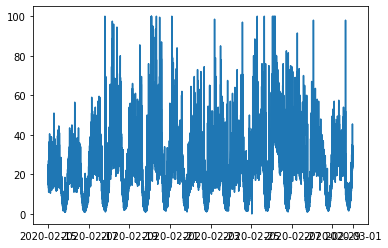

                     CpuUtilizationAverage
TimeStampUtc                              
2020-02-15 00:00:00                   19.0
2020-02-15 00:01:00                   18.0
2020-02-15 00:02:00                   20.0
2020-02-15 00:03:00                   16.5
2020-02-15 00:04:00                   25.0
...                                    ...
2020-02-29 23:55:00                   28.5
2020-02-29 23:56:00                   33.0
2020-02-29 23:57:00                   34.5
2020-02-29 23:58:00                   24.0
2020-02-29 23:59:00                   31.0

[21600 rows x 1 columns]


In [35]:
dataset = 'WI'
data = pd.read_csv('samples/' + dataset + '.csv', delimiter=',', index_col=0, parse_dates=True)

plt.plot(data)
plt.show()
print(data)


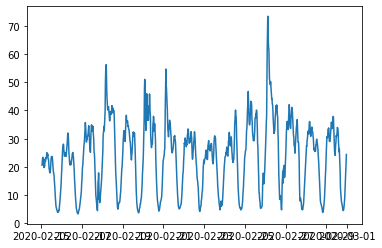

((360, 1), (1077, 1))

In [100]:
freq = 60
downsampled = data.resample(str(freq) + 'T').mean()
seasonality = (24 * 60) // freq
split = 0.8
# Split into train and test datasets
raw_values = np.asarray(downsampled['CpuUtilizationAverage'])
tsize = math.floor(raw_values.shape[0] * split)
train, test = model_selection.train_test_split(raw_values, train_size=tsize)
seasonality
plt.plot(rolling)
plt.show()
downsampled.shape


0 0


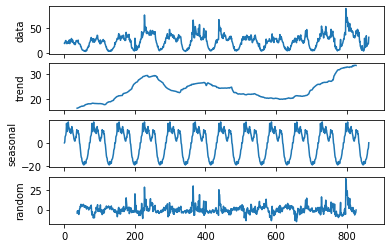

<Figure size 432x288 with 0 Axes>

In [97]:
# Find differencing coefficient
# KY, ND, CA, DE, OK, NE, MD, WI, ID, WV, NC, WY, VT, IA
diff = pm.arima.ndiffs(train, max_d=5)

seasonal_diff = pm.arima.nsdiffs(train, seasonality, max_D=5)
print(diff, seasonal_diff)

#Decompose
decomposed_tuple = pm.arima.decompose(train, 'additive', seasonality)
pm.utils.visualization.decomposed_plot(decomposed_tuple , figure_kwargs={})
plt.savefig('test.png')
diff = 1

In [106]:
mean = train.mean()
mean_forecasts = np.ones(test.shape[0]) * mean
naive_forecasts = np.ones(test.shape[0]) * train[-1]
naive_sliding = np.array([raw_values[train.shape[0] + i - 1] for i in range(test.shape[0])])

In [101]:
from datetime import datetime

start = datetime.now()
p, d, q= (1,0,1)
P, D, Q = (3, 0, 3)
model = arima.ARIMA((p,d,q), (P,D,Q,seasonality), method='powell')
res = model.fit(train)
end = datetime.now()
print("Trained in " + str(end - start))
forecasts = model.predict(test.shape[0])
resid = model.resid()
# model = pm.auto_arima(train, seasonal=True, m=seasonality, d=diff, D=seasonal_diff, suppress_warnings=False, start_p=2, start_q=2, max_Q=3, max_P=3, max_p=3, max_d=3, order=5)


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Trained in 0:02:04.451637


In [102]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  288
Model:             SARIMAX(1, 0, 1)x(3, 0, [1, 2, 3], 24)   Log Likelihood                -735.582
Date:                                    Wed, 10 Jun 2020   AIC                           1491.165
Time:                                            17:41:48   BIC                           1527.794
Sample:                                                 0   HQIC                          1505.843
                                                    - 288                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0061      0.050      0.122      0.903      -0.092       0.105
ar.L1          0.9361      0.017     56.075      0.000       0.903       0.969
ma.L1          0.2161      0.053      4.098      0.000       0.113       0.319
ar.S.L24      -0.2995      0.246     -1.218      0.223      -0.782       0.183
ar.S.L48       0.6594      0.278      2.369      0.018       0.114       1.205
ar.S.L72       0.6324      0.307      2.061      0.039       0.031       1.234
ma.S.L24       0.6060      0.440      1.379      0.168      -0.256       1.468
ma.S.L48      -0.5585      0.545     -1.025      0.305      -1.626       0.509
ma.S.L72      -0.8239      0.305     -2.700      0.007      -1.422      -0.226
sigma2         7.8863      1.349      5.847      0.000       5.243      10.530
===================================================================================
Ljung-Box (Q):                      142.89   Jarque-Bera (JB):               167.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.06   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [103]:
import pickle
filename = f"./arima_models/{dataset}_{freq}M_(1_0_1)_(3_0_3)_{train_frac}"
pickle.dump(model, open( filename, "wb" ))


288


ValueError: x and y must have same first dimension, but have shapes (72,) and (36,)

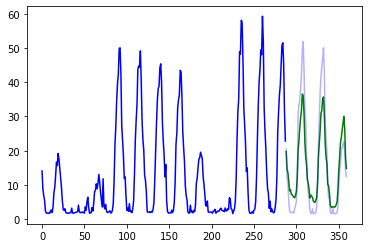

In [105]:

x = np.arange(train.shape[0] + test.shape[0])
print(train.shape[0])
plt.plot(x[:train.shape[0]], train, c='blue')
plt.plot(x[train.shape[0]:], forecasts, c='green')
plt.plot(x[train.shape[0]:], raw_values[tsize:], c='blue', alpha=0.3)
plt.title('CPU Prediction with SARIMA')
plt.xlabel('Time (Hours since start)')
plt.ylabel('CPU Usage')
plt.figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k')
plt.show()


In [110]:
forecasts = []
for point in test:
    forecasts.append(model.predict(1))
    model.update(point, maxiter=1)
forecasts = np.array(forecasts)

/home/rayan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:567: Co

/home/rayan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:567: Co

KeyboardInterrupt: 

In [108]:
eps = 1e-5
# Mean Average Percent Error
def mape(preds, labels):
    err = 0
    for (pred, label) in zip(preds, labels):
        denum = np.absolute(label) if label !=0 else max(labels) # this might be wrong
        err += (np.absolute(pred-label) / denum)
    err /= preds.shape[0]
    print("MAPE - {}".format(err))
    return err
    
# Brier Score or Mean Squared Error
def mse(preds, labels):
    err = np.sum(np.power(preds-labels, 2)) / preds.shape[0]
    print("MSE - {}".format(err))
    return err
    
# Root Mean Squared Error
def rmse(preds, labels):
    err = np.power(mse(preds, labels), 0.5)
    print("RMSE - {}".format(err))
    return err

def print_error(preds, labels):
    mean_err = np.sum(np.absolute(preds-labels)) / preds.shape[0]
    print("Mean Error - {}".format(mean_err)) # average difference from true
    brier_score = np.sqrt(np.sum(np.power(preds-labels, 2)) / preds.shape[0])
    print("Root Mean Square Error - {}".format(brier_score))
    mape(preds, labels)
print("ARIMA PREDICTIONS")
print_error(forecasts,test[:test.shape[0]])
print("\nNAIVE PREDICTIONS")
print_error(naive_forecasts, test[:test.shape[0]])
print("\nNAIVE SLIDING")
print_error(naive_sliding, test[:test.shape[0]])
print("\nMEAN PREDICTIONS")
print_error(mean_forecasts, test[:test.shape[0]])


ARIMA PREDICTIONS
Mean Error - 5.361653906207631
Root Mean Square Error - 6.543416661364196
MAPE - 0.8380496460425122

NAIVE PREDICTIONS
Mean Error - 15.166319444444444
Root Mean Square Error - 16.856415962749168
MAPE - 4.39169839371005

NAIVE SLIDING
Mean Error - 3.5641203703703703
Root Mean Square Error - 5.158069455977557
MAPE - 0.3329575196636359

MEAN PREDICTIONS
Mean Error - 12.602286683384774
Root Mean Square Error - 15.592225517739319
MAPE - 2.4286602113628954


In [78]:
# assumes we have a model, model
from datetime import datetime

# Window size of n_samples/5, one step, one forecast horizon
start = datetime.now()
cv = model_selection.SlidingWindowForecastCV(step=30, h=30, window_size=20)
sliding_forecasts = model_selection.cross_val_predict(model, raw_values)
end = datetime.now()
start - end, sliding_forecasts

/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


KeyboardInterrupt: 

In [212]:
# assumes we have a model, model
from datetime import datetime

print(raw_values.shape)
# Window size of n_samples/5, one step, one forecast horizon
start = datetime.now()
cv = model_selection.RollingForecastCV(step=30, h=50, initial=120)
sliding_forecasts = model_selection.cross_val_predict(model, raw_values)
end = datetime.now()
start - end, sliding_forecasts

(180,)


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  war

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

0 samples/ND.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


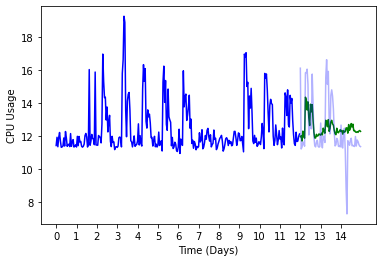

1.061722392523492
1 samples/KY.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


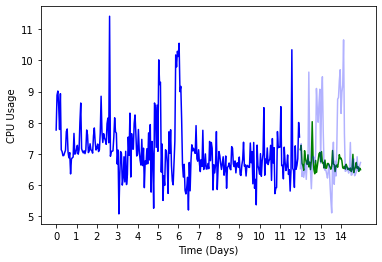

0.79253082039321
2 samples/RI.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


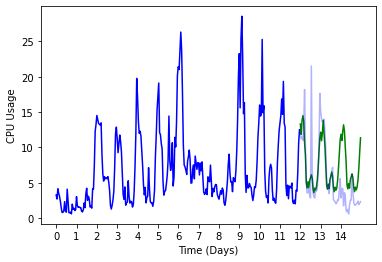

2.958517593698637
3 samples/CA.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


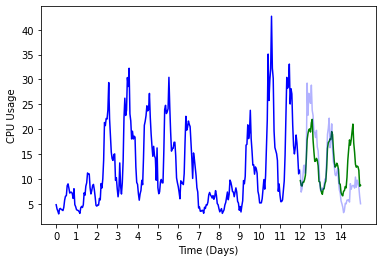

3.634070588964702
4 samples/DE.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


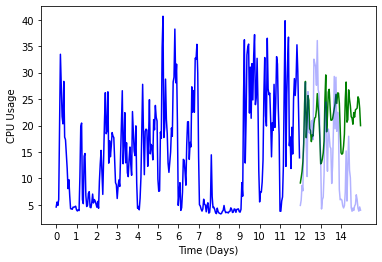

8.696185202210309
5 samples/OK.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


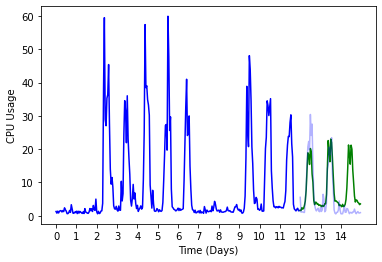

4.248164045759334
6 samples/NE.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


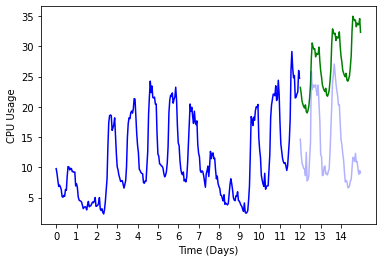

13.099877275483587
7 samples/MD.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


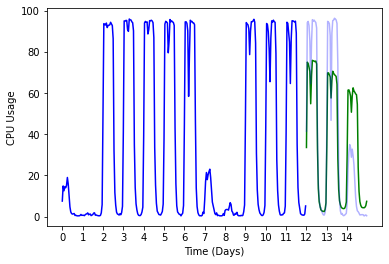

16.119859154455256
8 samples/MA.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


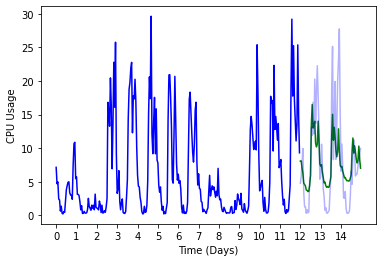

3.5818388927267506
9 samples/ID.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


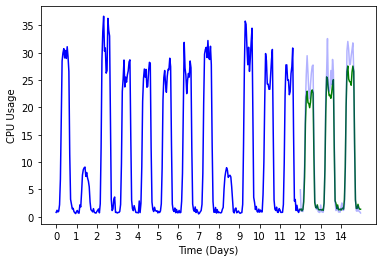

1.813827359174486
10 samples/VA.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


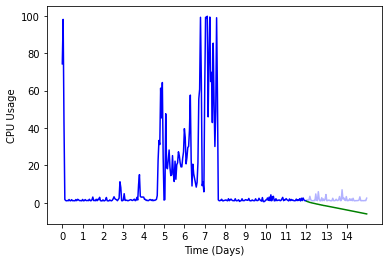

4.475964735951882
11 samples/TX.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


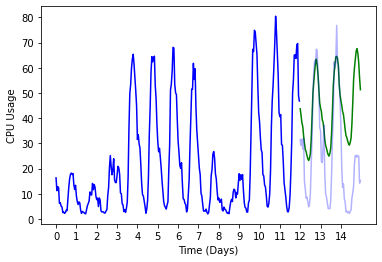

17.787135400734524
12 samples/CT.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


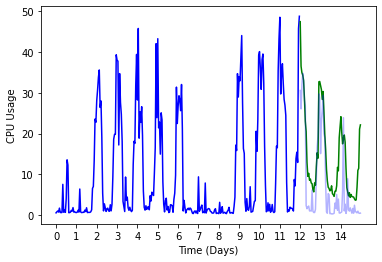

7.2329757085082935
13 samples/MO.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


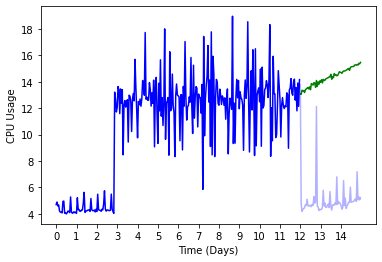

9.292482994412962
14 samples/GA.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


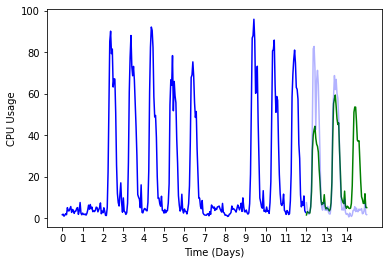

11.404660367072545
15 samples/IL.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


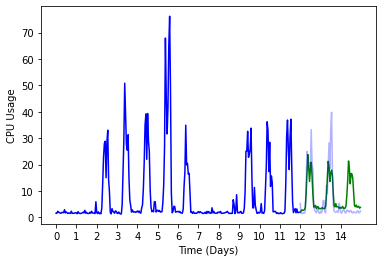

4.262007923470275
16 samples/NJ.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


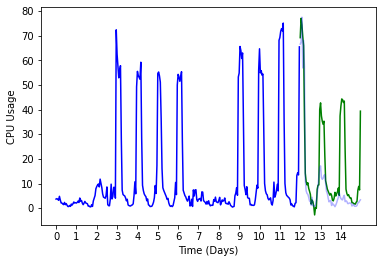

8.61388745352769
17 samples/AZ.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


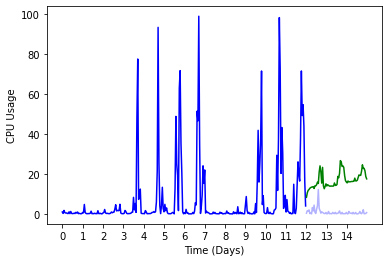

15.940767641788963
18 samples/AL.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


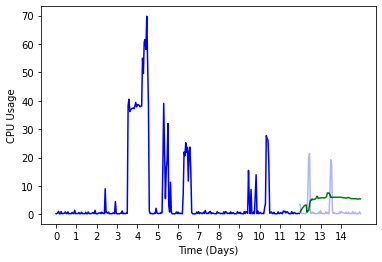

5.442848320739663
19 samples/AR.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


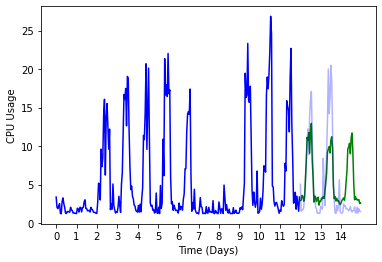

2.836197770903269
20 samples/WV.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


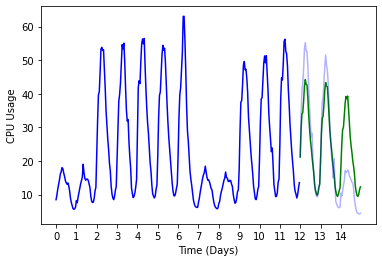

6.975248157219644
21 samples/MI.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


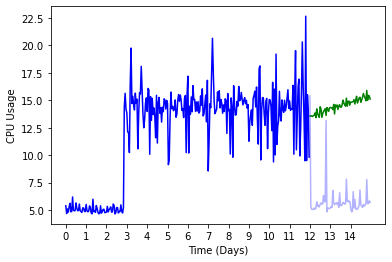

8.740623302895434
22 samples/NY.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


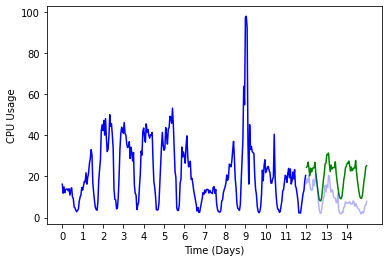

11.035300917673972
23 samples/TN.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


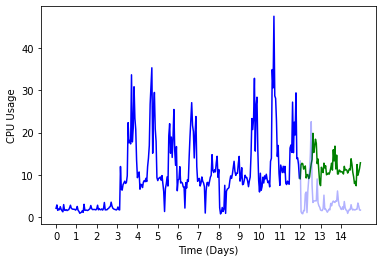

8.633738953795753
24 samples/AK.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


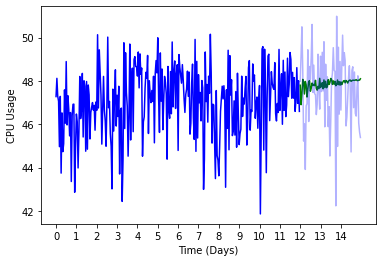

1.357892946195855
25 samples/OR.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


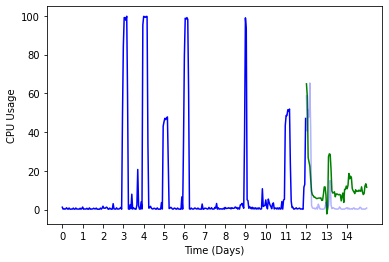

10.140601863079276
26 samples/NV.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


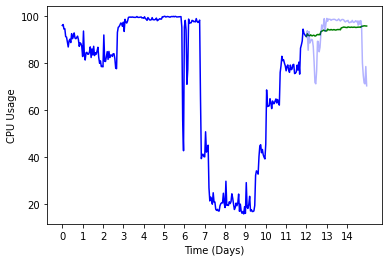

5.333795321636413
27 samples/KS.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


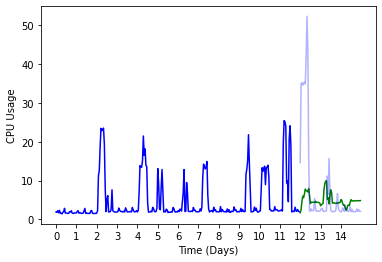

6.562841103162653
28 samples/NC.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


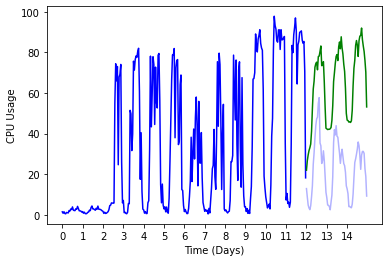

41.19375055654208
29 samples/ME.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


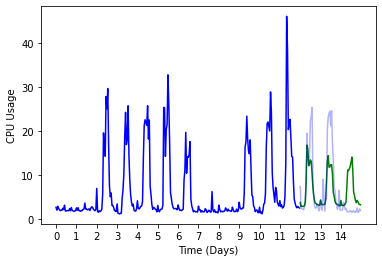

3.7194740038972336
30 samples/WY.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


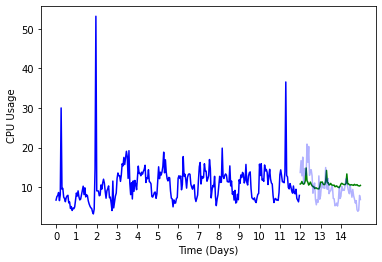

2.7951597683597478
31 samples/MN.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


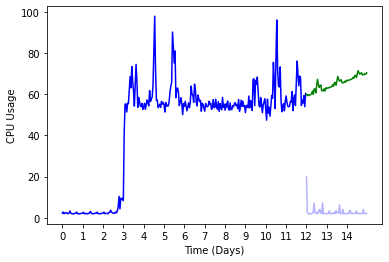

62.51600262122386
32 samples/VT.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


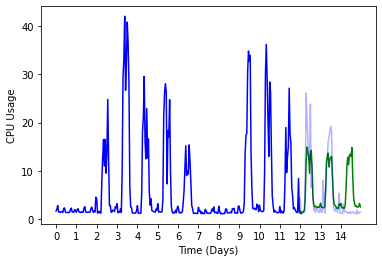

3.0883259128582314
33 samples/WA.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


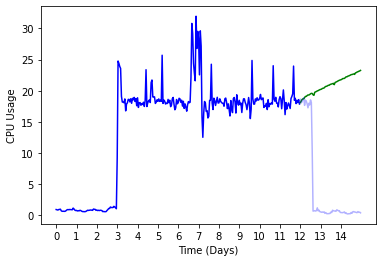

16.840093221885834
34 samples/NH.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


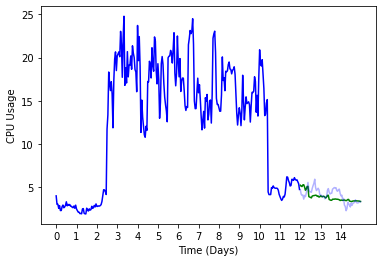

0.6356687088955096
35 samples/CO.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


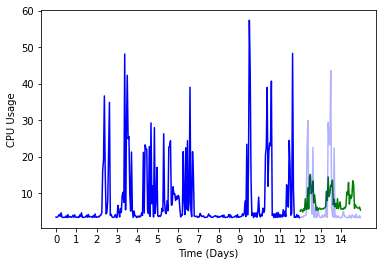

4.735375779435344
36 samples/MT.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


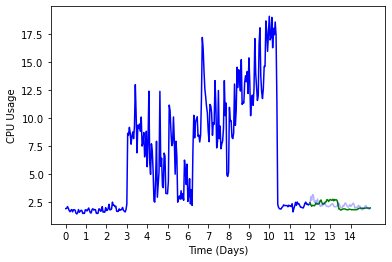

0.31528870543920695
37 samples/NM.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


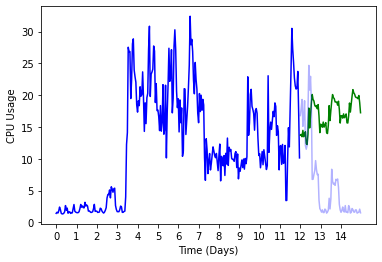

12.084446420540925
38 samples/SD.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


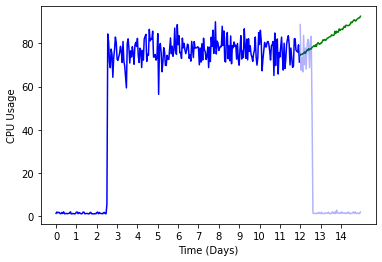

67.75814902799804
39 samples/MS.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


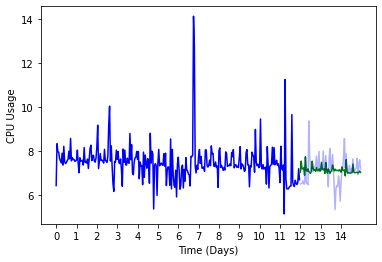

0.4232557178845693
40 samples/IA.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


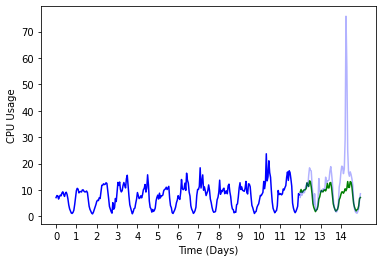

4.528101777933813
41 samples/OH.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


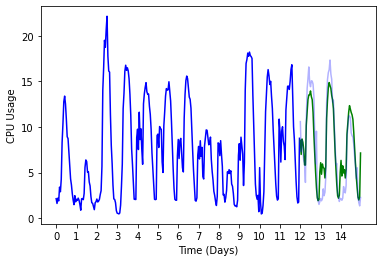

1.6872818857471485
42 samples/PA.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


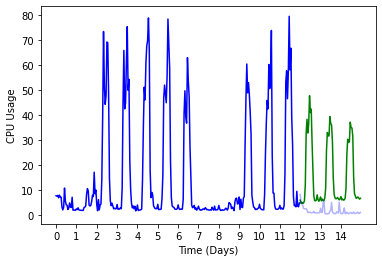

14.783482375037046
43 samples/HI.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


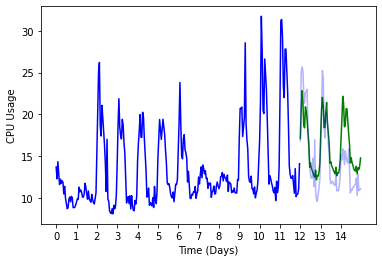

2.3902229905342156
44 samples/IN.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


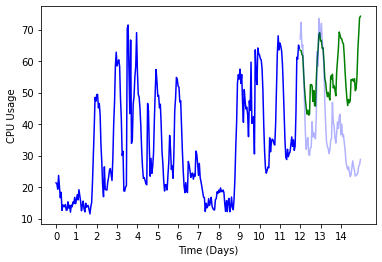

17.318590903345
45 samples/WI.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


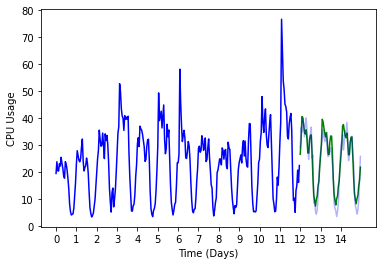

2.944287359717415
46 samples/FL.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


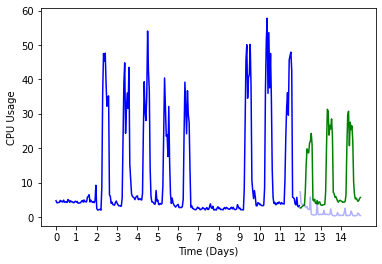

10.068492888230786
47 samples/UT.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


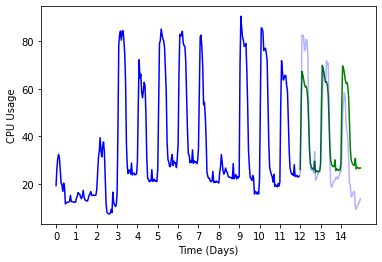

9.52509799822894
48 samples/LA.csv
0 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


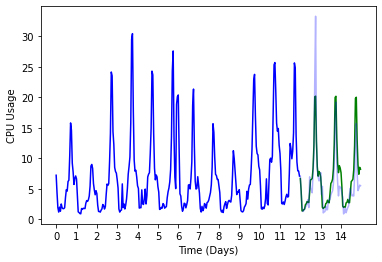

1.9041412301003737
49 samples/SC.csv
1 0


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(360,) [  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336]


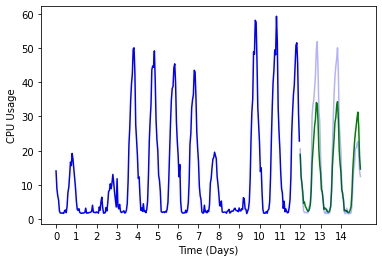

5.072528396180768


In [132]:
filenames = glob.glob('samples/*.csv')
mean_results = []
forecast_results = []
naive_results = []

def get_mean_error(preds, labels):
    return np.sum(np.absolute(preds-labels)) / preds.shape[0]
    
def get_mse(preds, labels):
    return np.sum(np.power(preds-labels, 2)) / preds.shape[0]

def normalize(data_min, data_max, data):
    return (data-data_min)/(data_max-data_min)

def get_normal_mean_error(preds, labels, _min, _max):
   # _preds = normalize(_min, _max, preds)
    #_labels = normalize(_min, _max, labels)
    return get_mean_error(preds, labels)

for i, file in enumerate(filenames):
    print(i, file)
    data = pd.read_csv(file, delimiter=',', index_col=0, parse_dates=True)
    
    freq = 60
    hourly = data.resample(str(freq) + 'T').mean()
    seasonality = (24 * 60) // freq

    # Split into train and test datasets
    raw_values = np.asarray(hourly['CpuUtilizationAverage'])
    tsize = math.floor(raw_values.shape[0] * 0.8)
    train, test = model_selection.train_test_split(raw_values, train_size=tsize)
    
    mean = train.mean()
    mean_forecasts = np.ones(test.shape[0]) * mean
    naive_forecasts = np.ones(test.shape[0]) * train[-1]
    
    diffs = arima.ndiffs(train)
    nsdiffs =arima.nsdiffs(train, seasonality)
    print(diffs, nsdiffs)
    model = arima.ARIMA((1,diffs,1), (3,nsdiffs,3,seasonality), method='powell')
    res = model.fit(train)
    forecasts = model.predict(test.shape[0])
    
    fig, ax = plt.subplots()
    x = np.arange(raw_values.shape[0])
    plt.plot(x[:tsize], train, c='blue')
    plt.plot(x[tsize:], forecasts, c='green')
    plt.plot(x[tsize:], raw_values[tsize:], c='blue', alpha=0.3)
    #plt.title(f"CPU Prediction with SARIMA (dataset 
    plt.xlabel('Time (Days)')
    plt.ylabel('CPU Usage')
    ticks = np.arange(0, raw_values.shape[0], seasonality)
    print(raw_values.shape, ticks)
    tick_labels = [str(label) for label in ticks // seasonality]
    ax = plt.gca()
    plt.xticks(ticks)
    ax.set_xticklabels(tick_labels)
    plt.show()
    
    err_fn = get_normal_mean_error
    _min, _max = np.min(raw_values), np.max(raw_values)
    forecast_results.append(err_fn(forecasts, test, _min, _max))
    mean_results.append(err_fn(mean_forecasts, test, _min, _max))
    naive_results.append(err_fn(naive_forecasts, test, _min, _max))
    print(err_fn(forecasts, test, _min, _max))

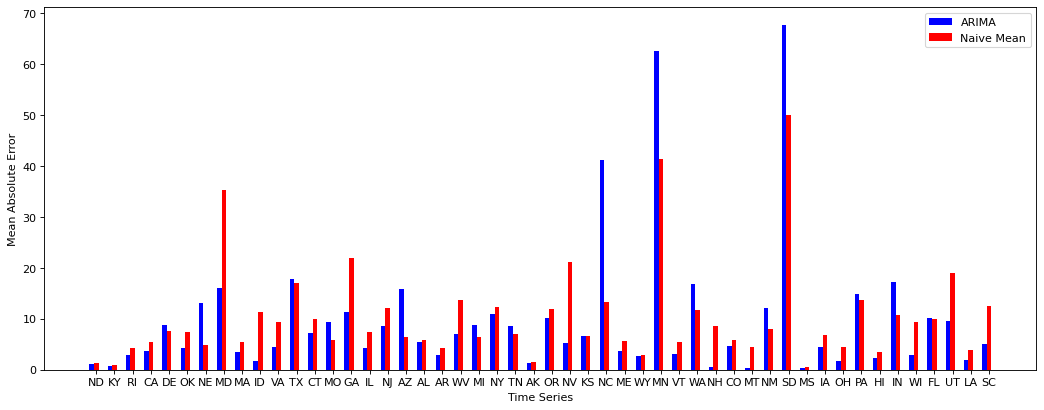

In [133]:
from matplotlib.pyplot import figure
trim_filenames = [filename.split('/')[1].split('.')[0] for filename in filenames]
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
X = np.arange(50)
handle1 = plt.bar(X, forecast_results, color='blue', width = 0.25, tick_label=trim_filenames, label = 'ARIMA')
handle2 = plt.bar(X+0.25, mean_results, color='red', width = 0.25, tick_label=trim_filenames, label = 'Naive Mean')
plt.legend(handles = [handle1, handle2])
plt.ylabel("Mean Absolute Error")
plt.xlabel("Time Series")

tot = 0
for arima_mae, mean_mae in zip(forecast_results, mean_results):
    if (arima_mae < mean):
        tot += 1
tot * 2
plt.savefig('arima_all.png', dpi=200, bbox_inches='tight')

# Normalize Data Eq


$\dfrac{x - min(x)}{(range)}$

In [135]:
index = trim_filenames.index('SD')
forecast_results[index], mean_results[index]

38